In [11]:
import numpy as np

# Load the dataset
data = np.load('dataset_new_200k_bi.npz')
X = data['values']
y = data['classes']

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and data loaders
#train_dataset = CustomDataset(X_train, y_train)
#test_dataset = CustomDataset(X_test, y_test)

#batch_size = 64
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=8)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [13]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from torch.optim import Adam
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm


def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [14]:
def train(
    model: nn.Module,
    data_loader: DataLoader,
    optimizer: Optimizer,
    loss_fn,
    device: torch.device,
) -> tuple[float, float]:
    model.train()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc="Train"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()

        optimizer.step()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total

In [15]:
@torch.inference_mode()
def evaluate(
    model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device
) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc="Evaluate"):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total

In [16]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str,
):
    plt.figure(figsize=(16, 8))

    plt.title(title + " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + " accuracy")

    plt.plot(train_accuracy, label="Train accuracy")
    plt.plot(valid_accuracy, label="Valid accuracy")
    plt.legend()
    plt.grid()

    plt.show()

In [17]:
def whole_train_valid_cycle(
    model, train_loader, valid_loader, optimizer, loss_fn, device, threshold, title
):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(200):
        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn, device
        )
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)

        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )

        if valid_accuracy >= threshold:
            break

In [18]:
def main(func, threshold, title):
    set_seed(0xDEADF00D)

    # Create datasets and data loaders
    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)

    batch_size = 20480
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = func(8,2).to(device)

    optimizer = Adam(model.parameters(), lr=1e-4)
    # Compute class weights
    # class_sample_counts = np.bincount(y_train)
    # class_weights = 1. / class_sample_counts
    # weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # # # Define the loss function with class weights
    # loss_fn = nn.CrossEntropyLoss(weight=weights)
    loss_fn = nn.CrossEntropyLoss()

    whole_train_valid_cycle(
        model, train_loader, test_loader, optimizer, loss_fn, device, threshold, title
    )

    #torch.save(predict(model, valid_loader, device), "prediction.pt")

In [19]:
def create_model(n_inputs, n_outputs):
    return nn.Sequential(

        nn.Linear(n_inputs, 32),
        nn.BatchNorm1d(32),
        nn.Dropout(p=0.),
        nn.LeakyReLU(),
        nn.Linear(32, 1024),
        nn.BatchNorm1d(1024),
        nn.Dropout(p=0.),
        nn.LeakyReLU(),
        nn.Linear(1024, 4096),
        nn.BatchNorm1d(4096),
        nn.Dropout(p=0.),
        nn.LeakyReLU(),
        nn.Linear(4096, 4096),
        nn.BatchNorm1d(4096),
        nn.Dropout(p=0.),
        nn.LeakyReLU(),
        nn.Linear(4096, 1024),
        nn.BatchNorm1d(1024),
        nn.Dropout(p=0.),
        nn.LeakyReLU(),
        nn.Linear(1024, n_outputs)
    )

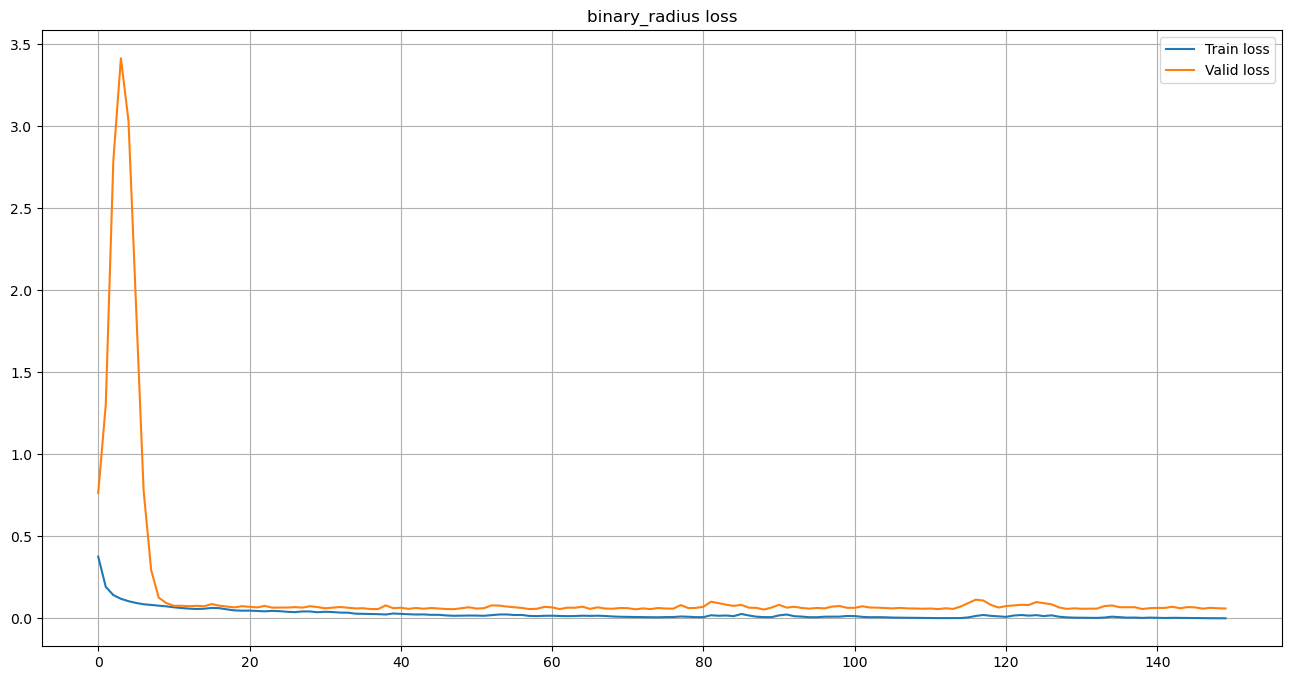

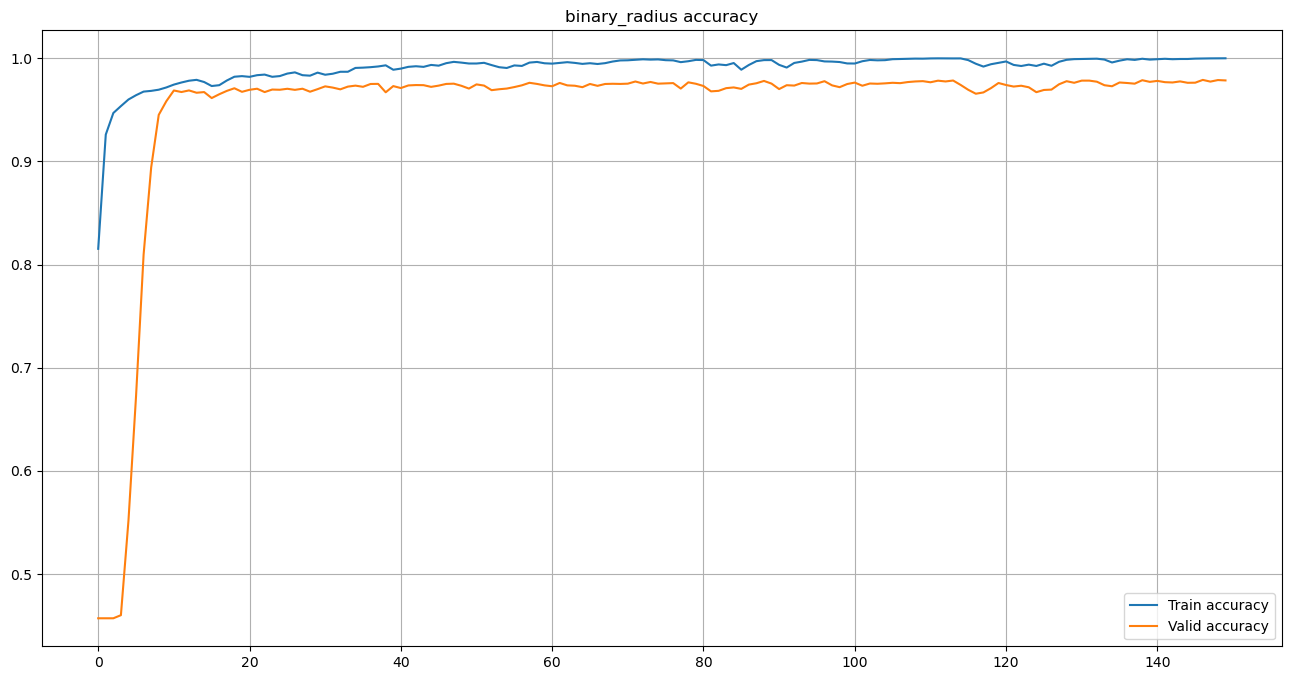

Train:  78%|███████▊  | 7/9 [00:02<00:00,  2.56it/s]


KeyboardInterrupt: 

In [20]:
main(create_model, 0.99, 'binary_radius')